In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

ImportError: cannot import name 'Timedelta' from 'pandas._libs.tslibs' (C:\ProgramData\Anaconda3\lib\site-packages\pandas\_libs\tslibs\__init__.py)

Считаем изображения.

In [ ]:
dir_text = 'Text/' 
dir_non_text = 'Nontext/' 

In [ ]:
text_imgs = []
non_text_imgs = []

In [ ]:
for filename in os.listdir(dir_text):
    if filename.endswith('tif') or filename.endswith('TIF'): 
        text_imgs += [plt.imread('Text/{}'.format(filename))]

for filename in os.listdir(dir_non_text):
    if filename.endswith('jpg') or filename.endswith('JPG'): 
        non_text_imgs += [plt.imread('Nontext/{}'.format(filename))]

Проверим, что нам удалось считать изображения.

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(text_imgs[0])
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.imshow(non_text_imgs[0])
plt.show()

# #1 Создание датасета

Для начала разберемся, что означают фичи:

* ***ВlackCount*** - количество черных пикселей в прямоугольнике
* ***WhiteHolesCount*** - количество белых дыр в прямоугольнике (при этом, как я понял из дальнейшего анализа, учитываются только "внешние" дыры, то есть дыра внутри дыры учитываться не будет)
* ***HorzStrokesCount*** - количество горизонатальных линий
* ***VertStrokesCount***  - количество вертиальных линий
* ***MaxHorzStrokeLength*** - максимальная длина горизонтальной линии

In [ ]:
from xml.dom import minidom
from tqdm import tqdm, tqdm_notebook

In [ ]:
def parser(directory):
    
    """
    Функция для преобразования XML файлов в формат Pandas DataFrame
    
    directory - путь до XML файла
    
    return: объект pd.DataFrame с информацией, извелеченной из XML файла
    
    """
    
    # потом соберем в этот датафрейм данные по текстовым объектам
    data = pd.DataFrame(columns=['num', 'BlackCount', 'WhiteHolesCount', 
                                 'HorzStrokesCount', 'VertStrokesCount', 'MaxHorzStrokeLength', 
                                 'Right', 'Left', 'Top', 'Bottom'])

    # количество добавленных в датафрейм объектов
    count_objects = 0

    # номер текущего файла 
    file_num = 1

    # парсим XML-файлы для датафрейма
    for filename in tqdm_notebook(os.listdir(directory)):
            if filename.endswith('xml') or filename.endswith('XML'): 
                xmldoc = minidom.parse('{}{}'.format(directory, filename))
                itemlist = xmldoc.getElementsByTagName('WordFragment')

                for item in itemlist:
                    BlackCount = item.attributes['BlackCount'].value
                    WhiteHolesCount = item.attributes['WhiteHolesCount'].value
                    HorzStrokesCount = item.attributes['HorzStrokesCount'].value
                    VertStrokesCount = item.attributes['VertStrokesCount'].value
                    MaxHorzStrokeLength = item.attributes['MaxHorzStrokeLength'].value
                    childList = item.childNodes
                    for child in childList:
                        if child.nodeType!=child.TEXT_NODE:
                            Left = child.attributes['Left'].value
                            Top = child.attributes['Top'].value
                            Right = child.attributes['Right'].value
                            Bottom = child.attributes['Bottom'].value

                    data.loc[count_objects] = [file_num, BlackCount, WhiteHolesCount, HorzStrokesCount, 
                                 VertStrokesCount, MaxHorzStrokeLength, Right, 
                                 Left, Top, Bottom]                   
                    count_objects +=1
                file_num += 1
                
    return data

In [ ]:
text_data = parser('Text/')

In [ ]:
text_data.head()

In [ ]:
text_data.tail()

In [ ]:
non_text_data = parser('Nontext/')

In [ ]:
non_text_data.head()

In [ ]:
non_text_data.tail()

Посмотрим на некоторые статистики по полученным датасетам.

In [ ]:
text_data.describe()

In [ ]:
non_text_data.describe()

In [ ]:
# преобразуем значения в датасетах к формату float
text_data = text_data.astype(float)
non_text_data = non_text_data.astype(float)

# введем переменную target - индикатор текста: 1 - текстовый объект, 0 - не текстовый объект
text_data['target'] = 1
non_text_data['target'] = 0

# скорректируем нумерацию файлов
non_text_data['num'] += text_data['num'].max()

In [ ]:
gc.collect()

In [ ]:
data = pd.concat([text_data, non_text_data])

In [ ]:
data.info()

# #2 Визуализация bounding boxes

In [21]:
import matplotlib.patches as patches
from PIL import Image

def draw_img_with_boxes(data, isTextData=False, number_of_img = 1, count_to_draw = 10, box_to_draw_index=0):
    """
    Рисует изображение, выделяя объекты на нем в Bounding boxes - информация о прямоугольнике объекта.
    
    data - данные с объектами
    isTextData - True, если хотим работать с данными по текстовым объектам, иначе работаем с данным по НЕ текстовым объектам
    number_of_img - номер изображения, которое хотим нарисовать
    count_to _draw - количество объектов-прямоугольников, которые хотим выделить на изображении
    box_to_draw_index - номер объекта, для которого мы хотим нарисовать bounding box. Задается, только если count_to_draw = 1
    
    return: None
    """
    
    text_data = data[data.target == 1]
    non_text_data = data[data.target == 0]
    if isTextData:
        data = text_data
        imgs = text_imgs
    else:
        data = non_text_data
        imgs = non_text_imgs
        number_of_img += int(text_data['num'].max())
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(16,12))
    im = np.array(imgs[number_of_img- 13*int(not isTextData) - 1], dtype=np.uint8)

    # Display the image
    ax.imshow(im)

    assert count_to_draw <= data[data['num'] == number_of_img].shape[0]
    
    if count_to_draw == 1:
        first_index = box_to_draw_index
    else:
        first_index = data[data['num'] == number_of_img].index[0]
    
    for num in range(first_index, first_index + count_to_draw):
        # Create a Rectangle patch
        w = data['Right'][num] - data['Left'][num]
        h = data['Bottom'][num] - data['Top'][num]
        rect = patches.Rectangle((data['Left'][num],data['Top'][num]),w,h,linewidth=2,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.annotate(str(num + 1),xy=(data['Left'][num],data['Top'][num]))


    plt.show()

In [22]:
sns.set(style='white')

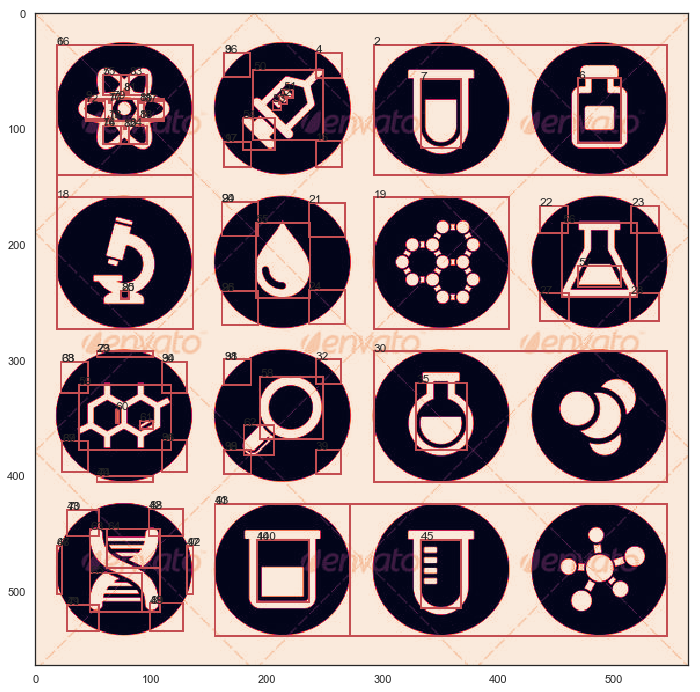

In [32]:
draw_img_with_boxes(data, isTextData=False, number_of_img = 1, count_to_draw = 100)

Кажется, в данных есть дубликаты. Удалим их.

In [33]:
print("Количество строк ДО удаления дупликатов в text_data: {}".format(text_data.shape[0]))
print("Количество строк ДО удаления дупликатов в non_text_data: {}".format(non_text_data.shape[0]))
non_text_data = non_text_data.drop_duplicates()
text_data = text_data.drop_duplicates()
print("Количество строк ПОСЛЕ удаления дупликатов в text_data: {}".format(text_data.shape[0]))
print("Количество строк ПОСЛЕ удаления дупликатов в non_text_data: {}".format(non_text_data.shape[0]))

Количество строк ДО удаления дупликатов в text_data: 24935
Количество строк ДО удаления дупликатов в non_text_data: 18074
Количество строк ПОСЛЕ удаления дупликатов в text_data: 22569
Количество строк ПОСЛЕ удаления дупликатов в non_text_data: 10431


In [34]:
text_data.reset_index(inplace=True, drop=True)
non_text_data.reset_index(inplace=True, drop=True)

In [38]:
data = pd.concat([text_data, non_text_data])

In [39]:
data.reset_index(inplace=True, drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 11 columns):
num                    33000 non-null float64
BlackCount             33000 non-null float64
WhiteHolesCount        33000 non-null float64
HorzStrokesCount       33000 non-null float64
VertStrokesCount       33000 non-null float64
MaxHorzStrokeLength    33000 non-null float64
Right                  33000 non-null float64
Left                   33000 non-null float64
Top                    33000 non-null float64
Bottom                 33000 non-null float64
target                 33000 non-null int64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB


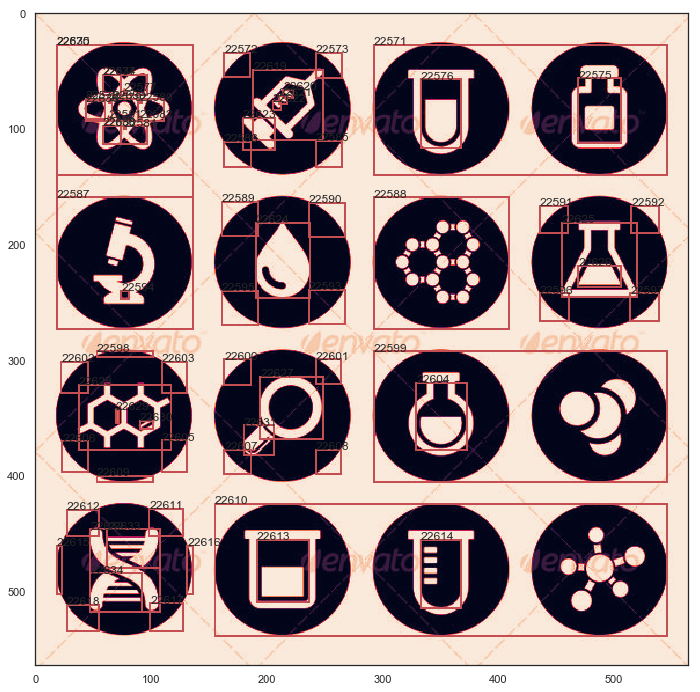

In [40]:
draw_img_with_boxes(data, number_of_img = 1, count_to_draw = 70)

In [41]:
# проверим соотносится ли изображение выше с данными в таблице
# 14 - это номер первого не текстового файла в датасете
data[data['num'] == 14].head(10)

,num,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Right,Left,Top,Bottom,target
22569,14.0,6956.0,1.0,202.0,205.0,92.0,136.0,18.0,27.0,140.0,0
22570,14.0,14651.0,2.0,371.0,348.0,95.0,546.0,292.0,27.0,140.0,0
22571,14.0,197.0,0.0,21.0,22.0,15.0,185.0,163.0,34.0,55.0,0
22572,14.0,220.0,0.0,22.0,23.0,16.0,265.0,242.0,34.0,56.0,0
22573,14.0,356.0,0.0,34.0,31.0,15.0,96.0,58.0,53.0,70.0,0
22574,14.0,1210.0,1.0,77.0,62.0,37.0,506.0,469.0,56.0,112.0,0
22575,14.0,1034.0,1.0,97.0,62.0,35.0,368.0,333.0,57.0,116.0,0
22576,14.0,5.0,0.0,2.0,3.0,3.0,79.0,76.0,67.0,69.0,0
22577,14.0,555.0,1.0,61.0,67.0,17.0,111.0,43.0,74.0,93.0,0
22578,14.0,3.0,0.0,2.0,2.0,2.0,65.0,63.0,75.0,77.0,0


Bounding boxes правильно соотносятся с данными в датасете, визуализация успешна.

# #3 Выбросы

In [42]:
data.describe()

,num,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Right,Left,Top,Bottom,target
count,33000.000000,3.300000e+04,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000,33000.000000
mean,11.866758,6.379015e+02,1.492606,54.700212,48.317000,11.407333,946.945394,922.581333,981.332939,1001.396697,0.683909
std,9.158244,3.708923e+04,49.666877,689.313612,608.592115,19.499174,635.971169,635.749094,674.084759,675.111863,0.464956
min,1.000000,1.000000e+00,0.000000,1.000000,1.000000,1.000000,7.000000,0.000000,0.000000,7.000000,0.000000
25%,4.000000,2.400000e+01,0.000000,6.000000,6.000000,5.000000,432.000000,404.000000,431.000000,451.000000,0.000000
50%,9.000000,1.140000e+02,0.000000,25.000000,18.000000,10.000000,829.000000,807.000000,815.000000,836.000000,1.000000
75%,15.000000,2.100000e+02,1.000000,39.000000,34.000000,16.000000,1292.000000,1272.000000,1432.000000,1454.000000,1.000000
max,34.000000,6.082504e+06,4592.000000,56663.000000,43078.000000,2191.000000,3235.000000,3180.000000,3347.000000,3369.000000,1.000000


Кажется, в данных есть очевидные выбросы. Например, слишком большие значения признаков ***WhiteHolesCount***, ***HorzStrokesCount***, ***VertStrokesCount*** и ***MaxHorzStrokeLength*** вызывают подозрения, проанализируем их.

In [43]:
def outlier_info(feature, cutoff):
    """
    Выводит информацию о выбросах для заданного признака.
    
    feature - признак, по которому мы хотим получить информацию о выбросах
    cutoff - значение признака, которое считаем крайним не выбросом 
            (если значение признака больше cutoff, то считаем его выбросом)
    
    return: None
    """
    
    plt.figure(figsize=(10,6))
    plt.scatter(data[data['target']==1].index, data[data['target']==1][feature], color='darkgreen', label='Text', alpha=0.7)
    plt.scatter(data[data['target']==0].index, data[data['target']==0][feature], color='red', label='NonText', alpha=0.7)
    plt.hlines(cutoff, data.index.min(), data.index.max(), linewidth=3, color='yellow', label='cutoff')
    plt.xlabel('Номер объекта')
    plt.ylabel('Значение признака {}'.format(feature))
    plt.title('Зависимость {} от объекта'.format(feature))
    plt.legend(fontsize=14)
    plt.show()
    
    ratio = data[data[feature] > cutoff].shape[0]/data.shape[0]
    print('Доля объектов со значением признака {} больше, чем {}, равна {}'.format(feature, cutoff, ratio))
    print('Таких объектов: {} из {}'.format(data[data[feature] > cutoff].shape[0], data.shape[0]))

Катоффы подобраны исходя из графиков.

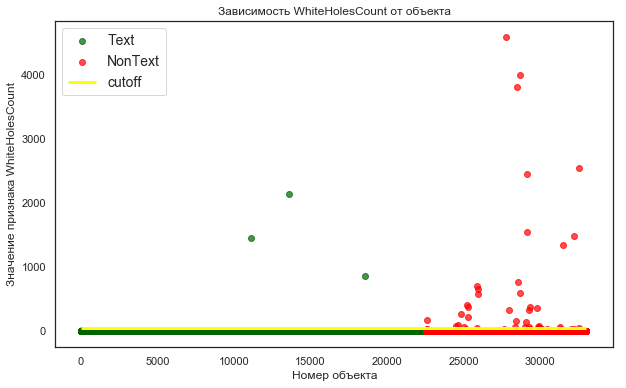

Доля объектов со значением признака WhiteHolesCount больше, чем 50, равна 0.0011515151515151514
Таких объектов: 38 из 33000


In [44]:
outlier_info('WhiteHolesCount', 50)

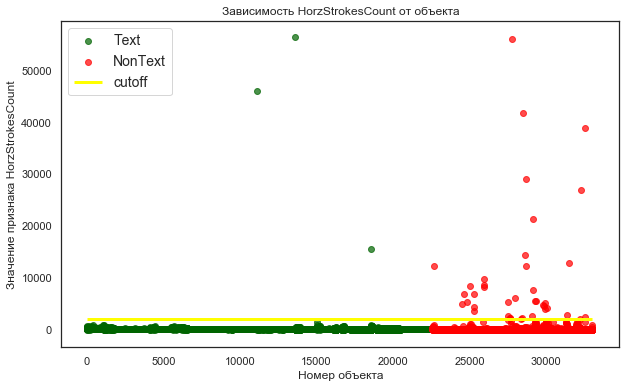

Доля объектов со значением признака HorzStrokesCount больше, чем 2000, равна 0.0012727272727272728
Таких объектов: 42 из 33000


In [45]:
outlier_info('HorzStrokesCount', 2000)

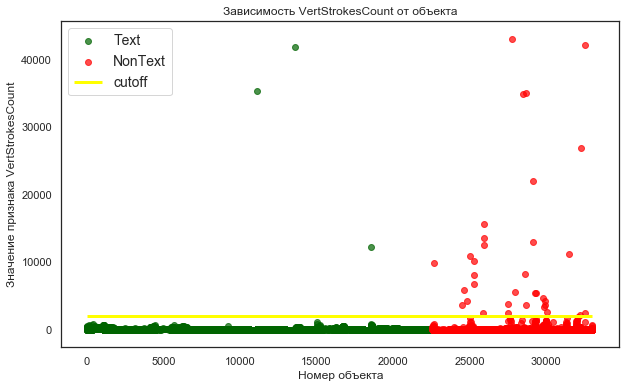

Доля объектов со значением признака VertStrokesCount больше, чем 2000, равна 0.0011212121212121212
Таких объектов: 37 из 33000


In [46]:
outlier_info('VertStrokesCount', 2000)

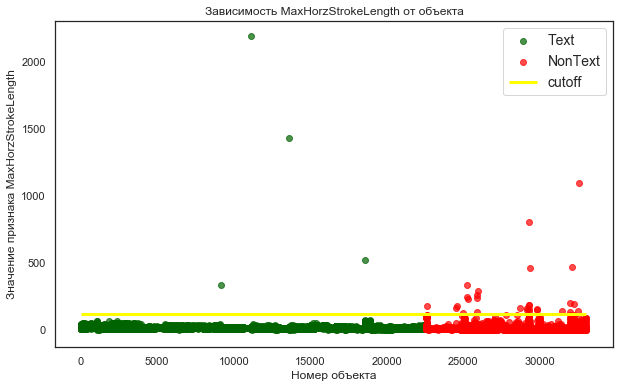

Доля объектов со значением признака MaxHorzStrokeLength больше, чем 120, равна 0.001
Таких объектов: 33 из 33000


In [47]:
outlier_info('MaxHorzStrokeLength', 120)

Заметим, что среди текстовых данных есть три очевидных выброса. Есть подозрение, что для каждого признака это одни и те же объекты.  
Проверим это.

In [48]:
data[(data['WhiteHolesCount']>50)&
     (data['HorzStrokesCount']>2000)&
     (data['VertStrokesCount']>2000)&
     (data['MaxHorzStrokeLength']>120)&
     (data['target']==1)]

,num,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Right,Left,Top,Bottom,target
11121,5.0,6082504.0,1448.0,46147.0,35358.0,2191.0,2201.0,0.0,0.0,2914.0,1
13620,6.0,2037937.0,2146.0,56663.0,41854.0,1432.0,1432.0,0.0,0.0,1656.0,1
18558,11.0,249526.0,862.0,15508.0,12199.0,517.0,522.0,0.0,0.0,637.0,1


Так и есть. Посмотрим, что это за объекты, возможно, их стоит удалить из обучающей выборки.

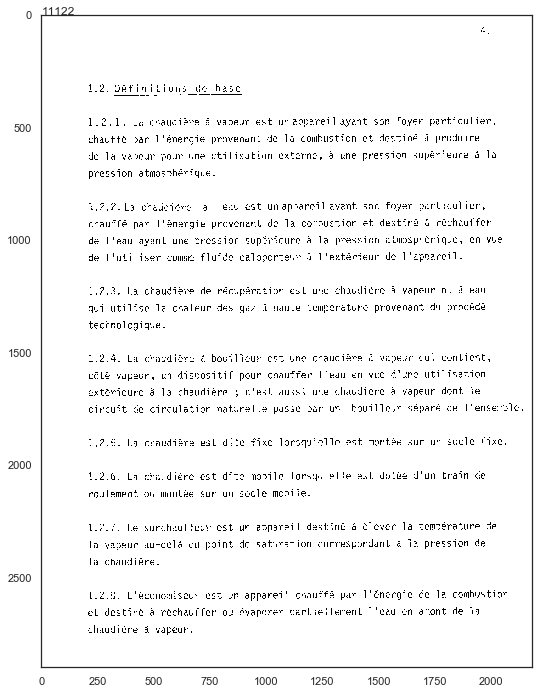

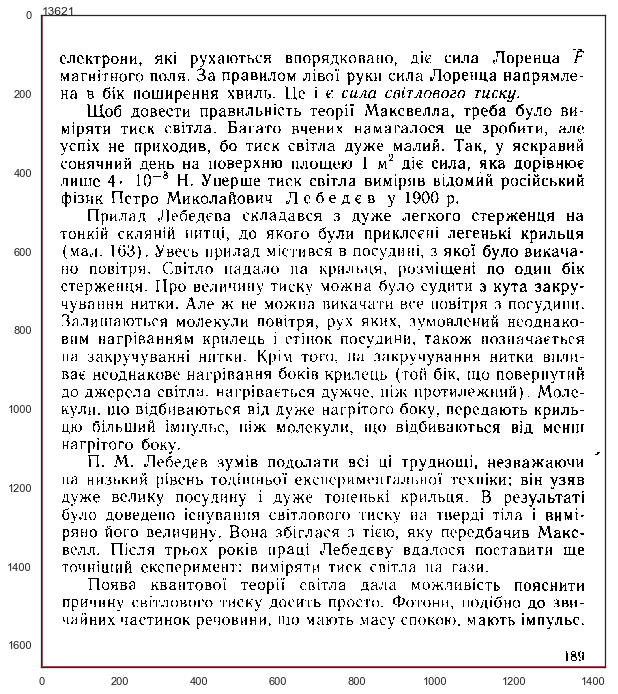

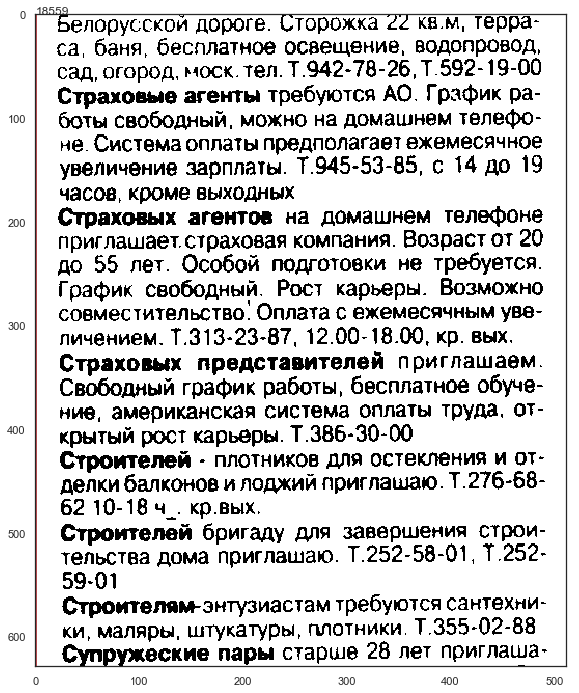

In [49]:
draw_img_with_boxes(data, isTextData=True, number_of_img = 5, count_to_draw = 1, box_to_draw_index=11121)
draw_img_with_boxes(data, isTextData=True, number_of_img = 6, count_to_draw = 1, box_to_draw_index=13620)
draw_img_with_boxes(data, isTextData=True, number_of_img = 11, count_to_draw = 1, box_to_draw_index=18558)

Как и ожидалось, это одни и те же выбросы. Алгоритм задетектировал изображение целиком. Удалим эти объекты, чтобы далее не смущать классификатор.

In [50]:
data.drop(11121, inplace=True)
data.drop(13620, inplace=True)
data.drop(18558, inplace=True)

Теперь заменим слишком большие значения признаков на значение **cutoff** для соответствующего признака, чтобы не вносить bias в модель.   
P.S.: это было актуально, так как изначально я рассматривал модель логистической регрессии. В итоге я перешел к моделям, основанным на деревьях, а они устойчивы к выбросам.

In [51]:
data['WhiteHolesCount'] = data['WhiteHolesCount'].apply(lambda x : 50 if x > 50 else x)
data['HorzStrokesCount'] = data['HorzStrokesCount'].apply(lambda x : 2000 if x > 2000 else x)
data['VertStrokesCount'] = data['VertStrokesCount'].apply(lambda x : 2000 if x > 2000 else x)
data['MaxHorzStrokeLength'] = data['MaxHorzStrokeLength'].apply(lambda x : 120 if x > 120 else x)

In [52]:
data.describe()

,num,BlackCount,WhiteHolesCount,HorzStrokesCount,VertStrokesCount,MaxHorzStrokeLength,Right,Left,Top,Bottom,target
count,32997.000000,3.299700e+04,32997.000000,32997.00000,32997.000000,32997.000000,32997.000000,32997.000000,32997.000000,32997.000000,32997.000000
mean,11.867170,3.843011e+02,0.532079,41.15953,35.869049,11.156742,946.905567,922.665212,981.422160,1001.329939,0.683880
std,9.158524,1.126881e+04,2.137810,101.38199,95.416228,9.124081,635.952698,635.717126,674.050451,675.047841,0.464967
min,1.000000,1.000000e+00,0.000000,1.00000,1.000000,1.000000,7.000000,0.000000,2.000000,7.000000,0.000000
25%,4.000000,2.400000e+01,0.000000,6.00000,6.000000,5.000000,432.000000,404.000000,431.000000,451.000000,0.000000
50%,9.000000,1.140000e+02,0.000000,25.00000,18.000000,10.000000,829.000000,807.000000,815.000000,836.000000,1.000000
75%,15.000000,2.100000e+02,1.000000,39.00000,34.000000,16.000000,1292.000000,1272.000000,1432.000000,1454.000000,1.000000
max,34.000000,1.903866e+06,50.000000,2000.00000,2000.000000,120.000000,3235.000000,3180.000000,3347.000000,3369.000000,1.000000


# #4 Feature Engineering

Введем новые признаки (как я понял, bounding boxes использовать можно).

In [53]:
# площадь прямоугольника
data['Area'] = (data['Right'] - data['Left'])*(data['Bottom'] - data['Top'])

In [54]:
# доля черных пикселей в прямоугольнике
data['BC_fraction'] = data['BlackCount']/data['Area']

In [55]:
# отношение количества горизонтальных линий к высоте прямоугольника
data['mean_horz_strokes'] = data['HorzStrokesCount']/(data['Bottom'] - data['Top'])

# отношение количества вертикальных линий к ширине прямоугольника
data['mean_vert_strokes'] = data['VertStrokesCount']/(data['Right'] - data['Left'])

In [56]:
# отношение количества черных пикселей к количеству штрихов
data['mean_black_count'] = data['BlackCount']/(data['VertStrokesCount'] + data['HorzStrokesCount'])

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

# заменяет значения категориального признака на среднее таргета по этому значению признака
# по сути mean target encoder, только с поправкой на количество элементов в категории
# если их слишком мало то смотрит на общее среднее
class SmoothedLikelihoodCol(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col
        self.good_columns = []
        self.y = None
        self.averages = dict()
        self.smoothing = dict()

    def fit(self, X, y=None):
        X = X.copy()
        self.y = y
        alpha = 1
        col = self.col
        
        self.good_columns += [col]
        train_col = X[col]
        target = y
        temp = pd.concat([train_col, target], axis=1)
        # Compute target mean 
        averages = temp.groupby(by=col)['target'].agg(["mean", "count"])

        # Compute smoothing
        smoothing = 1 / (1 + np.exp(-(averages["count"] - 1) / alpha))

        self.smoothing[col] = smoothing
        # Apply average function to all target data
        prior = target.mean()
        # The bigger the count the less full_avg is taken into account
        averages['target'] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        self.averages[col] = averages
                      
        return self

    def transform(self, X):
        gc.collect()
        X = X.copy()
        prior = self.y.mean()
        col = self.col
        test_col = X[col]
        target = self.y
        averages = self.averages[col]
        smoothing = self.smoothing[col]

        ft_tst_series = pd.merge(
        test_col.to_frame(col),
        averages.reset_index().rename(columns={'index': 'target', 'target': 'average'}),
        on=col,
        how='left')['average'].rename(col + '_mean').fillna(prior)
        ft_tst_series.index = test_col.index
        X['smoothed_{}'.format(col)] = ft_tst_series 
        return X

К каким признакам применить технику Smoothed Likelihood?

In [58]:
for col in data.columns:
    print("Количество уникальных значений признака {} равно {}".format(col, np.unique(data[col]).shape[0]))

Количество уникальных значений признака num равно 34
Количество уникальных значений признака BlackCount равно 1956
Количество уникальных значений признака WhiteHolesCount равно 35
Количество уникальных значений признака HorzStrokesCount равно 571
Количество уникальных значений признака VertStrokesCount равно 533
Количество уникальных значений признака MaxHorzStrokeLength равно 96
Количество уникальных значений признака Right равно 2735
Количество уникальных значений признака Left равно 2713
Количество уникальных значений признака Top равно 2526
Количество уникальных значений признака Bottom равно 2517
Количество уникальных значений признака target равно 2
Количество уникальных значений признака Area равно 2332
Количество уникальных значений признака BC_fraction равно 10473
Количество уникальных значений признака mean_horz_strokes равно 3085
Количество уникальных значений признака mean_vert_strokes равно 2806
Количество уникальных значений признака mean_black_count равно 8685


У признаков ***WhiteHolesCount***, ***HorzStrokesCount***, ***VertStrokesCount***, ***MaxHorzStrokeLength*** не так много уникальных значений относительно других признаков, поэтому для Smoothed Likelihood выберем именно их. 

In [59]:
smoothed_cols = ['WhiteHolesCount', 'HorzStrokesCount', 'VertStrokesCount', 'MaxHorzStrokeLength']

# #5 Корреляционный анализ

Нет цели провести полный корреляционный анализ, но посмотреть на зависимости стоит, вдруг удастся заметить что-то интересное. Смотреть будем на корреляции Спирмана, так как нам интересны монотонные зависимости, а не только линейные. 

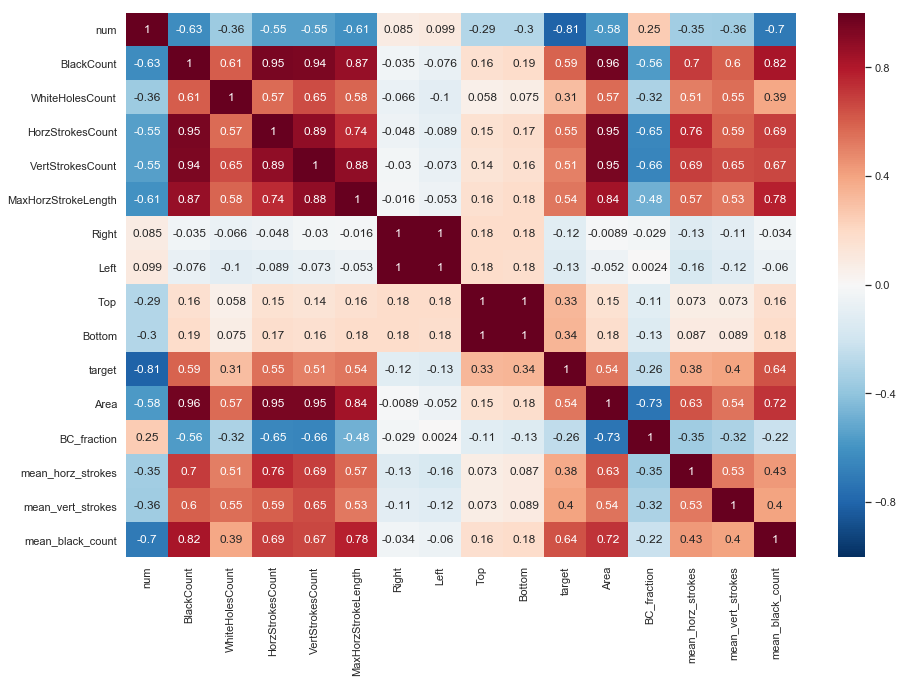

In [60]:
R = data.corr(method='spearman')
plt.figure(figsize=(15, 10))
sns.heatmap(R, vmin=-1, vmax=1, cmap='RdBu_r', annot=True)
plt.show()

Видим, что feature engineering проводили не зря - признак ***mean_black_count*** имеет наибольшую корреляцию с таргетом.

# #6 Модель: RandomForestClassifier

In [61]:
from sklearn.model_selection import train_test_split
X = data.drop(['num', 'target', 'Right', 'Left', 'Top', 'Bottom'], axis=1, inplace=False)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0)
steps = []
for col in smoothed_cols:
    steps += [('sm_{}'.format(col), SmoothedLikelihoodCol(col))]
    
steps += [('model', model)]

pipeline = Pipeline(steps)

In [65]:
pipeline.get_params()

{'memory': None,
 'steps': [('sm_WhiteHolesCount',
   SmoothedLikelihoodCol(col='WhiteHolesCount')),
  ('sm_HorzStrokesCount', SmoothedLikelihoodCol(col='HorzStrokesCount')),
  ('sm_VertStrokesCount', SmoothedLikelihoodCol(col='VertStrokesCount')),
  ('sm_MaxHorzStrokeLength', SmoothedLikelihoodCol(col='MaxHorzStrokeLength')),
  ('model',
   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
               oob_score=False, random_state=0, verbose=0, warm_start=False))],
 'sm_WhiteHolesCount': SmoothedLikelihoodCol(col='WhiteHolesCount'),
 'sm_HorzStrokesCount': SmoothedLikelihoodCol(col='HorzStrokesCount'),
 'sm_VertStrokesCount': SmoothedLikelihoodCol(col='VertStrokesCount'),
 'sm_MaxHorzSt

In [73]:
params = {'model__max_depth': [10, 15], 
          'model__n_estimators': [1000, 3000, 5000]}

rf_cv = GridSearchCV(pipeline, params, cv=3, verbose=15, scoring='roc_auc', n_jobs=4)
rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   46.7s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   47.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed: 10.0min remaining:  3.9min
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed: 11.5min remaining:  2.3min
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 16.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sm_WhiteHolesCount', SmoothedLikelihoodCol(col='WhiteHolesCount')), ('sm_HorzStrokesCount', SmoothedLikelihoodCol(col='HorzStrokesCount')), ('sm_VertStrokesCount', SmoothedLikelihoodCol(col='VertStrokesCount')), ('sm_MaxHorzStrokeLength', SmoothedLikelihoodCol(col='MaxHorzStrokeLength')), (...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'model__max_depth': [10, 15], 'model__n_estimators': [1000, 3000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=15)

In [74]:
best_est = rf_cv.best_estimator_
print('Лучшие параметры: {}'.format(rf_cv.best_params_))
print('Лучший AUC-ROC: {:4f}'.format(rf_cv.best_score_))

Лучшие параметры: {'model__max_depth': 15, 'model__n_estimators': 1000}
Лучший AUC-ROC: 0.967332


In [75]:
best_est.fit(X_train, y_train)
y_pred = best_est.predict(X_test)
y_pred_proba = best_est.predict_proba(X_test)

rf_results = (y_pred, y_pred_proba)

In [80]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def prediction_info(y_true, y_pred, y_pred_proba):
    
    print('Accuracy: {:4f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision (macro): {:4f}'.format(precision_score(y_true, y_pred, average='macro')))
    print('Precision (micro): {:4f}'.format(precision_score(y_true, y_pred, average='micro')))
    print('Recall (macro): {:4f}'.format(recall_score(y_true, y_pred, average='macro')))
    print('Recall (micro): {:4f}'.format(recall_score(y_true, y_pred, average='micro')))
    print('AUC-ROC: {:4f}'.format(roc_auc_score(y_true, y_pred_proba[:,1])))
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba[:,1])
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:,1])
    print('AUC-PR: {:4f}'.format(auc(recall, precision)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.title('PR-curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recall, precision, color='red')
    plt.fill_between(recall, precision, step='post', alpha=0.25, color='red')
    
    plt.subplot(1,2,2)
    plt.title('ROC-curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
    plt.plot(fpr, tpr,  color='red')
    plt.fill_between(fpr, tpr, step='post', alpha=0.25, color='red')
    
    plt.show()
    return precision, recall, thresholds
    

Accuracy: 0.918788
Precision (macro): 0.903649
Precision (micro): 0.918788
Recall (macro): 0.910686
Recall (micro): 0.918788
AUC-ROC: 0.966153
AUC-PR: 0.983974


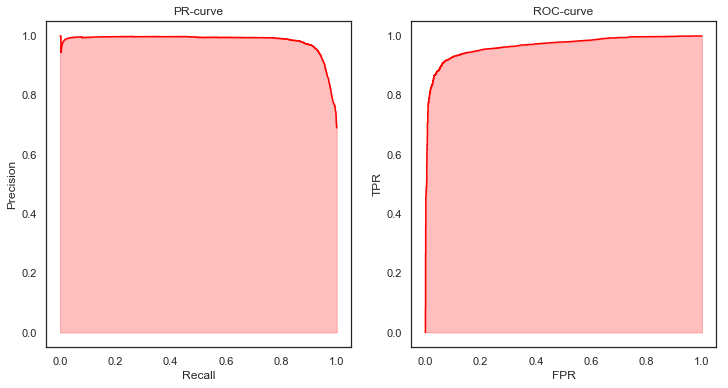

In [81]:
p, r, t = prediction_info(y_test, y_pred, y_pred_proba)

In [82]:
# запишем ошибки
eps_rf = np.array(abs(y_test-y_pred_proba[:, 1]))

# #7 Модель: XGBoost

In [83]:
class GoodStScaler(BaseEstimator, TransformerMixin):
    """
    Это по сути просто StandartScaler, но умеет возвращать pd.DataFrame() вместо np.array()
    """
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X, y=None):
        columns = X.columns
        X = np.array(X)
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        X = (X-self.mean)/(self.std+0.0001)
        X = pd.DataFrame(X)
        X.columns = columns
        return self

    def transform(self, X):
        gc.collect()
        columns = X.columns
        X = np.array(X)
        X = (X-self.mean)/(self.std+0.0001)
        X = pd.DataFrame(X)
        X.columns = columns
        return X

In [84]:
import xgboost as xgb

model = xgb.XGBClassifier()
steps = [('st_scaler', GoodStScaler())]
for col in smoothed_cols:
    steps += [('sm_{}'.format(col), SmoothedLikelihoodCol(col))]
    
steps += [('model', model)]

pipeline = Pipeline(steps)
print(pipeline.get_params())

{'memory': None, 'steps': [('st_scaler', GoodStScaler()), ('sm_WhiteHolesCount', SmoothedLikelihoodCol(col='WhiteHolesCount')), ('sm_HorzStrokesCount', SmoothedLikelihoodCol(col='HorzStrokesCount')), ('sm_VertStrokesCount', SmoothedLikelihoodCol(col='VertStrokesCount')), ('sm_MaxHorzStrokeLength', SmoothedLikelihoodCol(col='MaxHorzStrokeLength')), ('model', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))], 'st_scaler': GoodStScaler(), 'sm_WhiteHolesCount': SmoothedLikelihoodCol(col='WhiteHolesCount'), 'sm_HorzStrokesCount': SmoothedLikelihoodCol(col='HorzStrokesCount'), 'sm_VertStrokesCount': SmoothedLikelihoodCol(col='VertStrokesCount'), 'sm_MaxHorzS

In [85]:
params = {'model__n_estimators': [500, 800], 
          'model__max_depth': [7, 10], 
         'model__learning_rate': [0.1, 0.001]}

xgb_cv = GridSearchCV(pipeline, params, cv=3, verbose=18, scoring='roc_auc', n_jobs=4)
xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   55.1s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:  2.9min
[Parallel(

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('st_scaler', GoodStScaler()), ('sm_WhiteHolesCount', SmoothedLikelihoodCol(col='WhiteHolesCount')), ('sm_HorzStrokesCount', SmoothedLikelihoodCol(col='HorzStrokesCount')), ('sm_VertStrokesCount', SmoothedLikelihoodCol(col='VertStrokesCount')), ('sm_MaxHorzStrokeLength', SmoothedLikelihoodCol...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'model__n_estimators': [500, 800], 'model__max_depth': [7, 10], 'model__learning_rate': [0.1, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=18)

In [86]:
best_est = xgb_cv.best_estimator_
print('Лучшие параметры: {}'.format(xgb_cv.best_params_))
print('Лучший AUC-ROC: {:4f}'.format(xgb_cv.best_score_))

Лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 500}
Лучший AUC-ROC: 0.972496


In [87]:
best_est.fit(X_train, y_train)
y_pred = best_est.predict(X_test)
y_pred_proba = best_est.predict_proba(X_test)

xgb_results = (y_pred, y_pred_proba)

Accuracy: 0.926970
Precision (macro): 0.912323
Precision (micro): 0.926970
Recall (macro): 0.921290
Recall (micro): 0.926970
AUC-ROC: 0.972947
AUC-PR: 0.987970


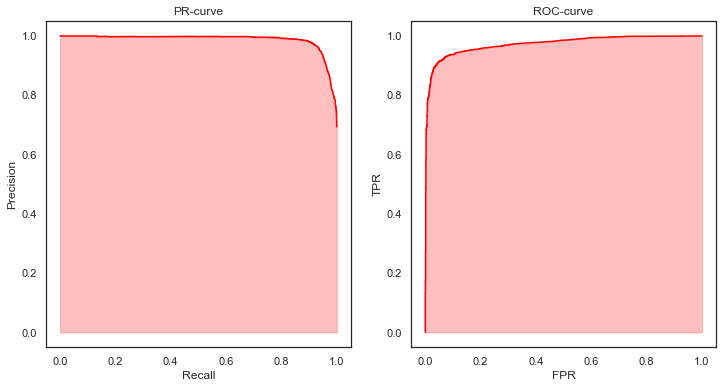

In [88]:
p, r, t = prediction_info(y_test, y_pred, y_pred_proba)

In [89]:
# запишем ошибки
eps_xgb = np.array(abs(y_test-y_pred_proba[:, 1]))

# #8 Анализ ошибок полученных классификаторов

XGboost показал более хорошие метрики, чем случайные леса. Проверим, является ли данное отличие статистически значимым. Для этого рассмотрим абсолютные ошибки предсказания по каждому объекту из тестовой части данных: $\epsilon_i = |y_i - \hat{y_i}|$. Проверим гипотезу однородности $H_0: F_{\epsilon}^{rf} = F_{\epsilon}^{xgb}$, где $F_{\epsilon}^{rf}$ - функция распределения ошибок случайных лесов, а $F_{\epsilon}^{xgb}$ - функция распределения ошибок градиентного бустинга. Альтернативу будем рассматривать $H_1: F_{\epsilon}^{rf} \leq F_{\epsilon}^{xgb}$. Альтернатива означает, что при фиксированном значении аргумента $x$ функции распределения $F$ вероятность того, что ошибка случайных лесов окажется меньше данного
значения $x$, меньше, чем вероятность того, что ошибка XGB окажется меньше данного значения $x$.

In [90]:
import scipy.stats as sps

def create_signed_test(x, y):
    """
    Критерий знаков. Используется в качестве непараметрического подхода для случая 
    связных выборок при исследовании систематического эффекта воздействия.
    
    x, y - выборки
    
    return: None
    """
    z = x - y
    z = np.array(z)
    s = np.sum(z > 0)
    n = z.shape[0]
    stat = (s - n / 2 - 1 / 2) / np.sqrt(n / 4)
    ans = sps.norm.sf(stat)
    print('Статистика критерия: {:4f}'.format(stat))
    print('p-value: {}'.format(ans))
    print('Оценка эффекта воздействия: {:4f}'.format(np.median(z)))
    k = int((n/2 - 1/2 - sps.norm.ppf(0.95)*np.sqrt(n/4)))
    z = sorted(z)
    print('Доверительный интервал для эффекта воздействия: {:4f} - {:4f}'.format(z[k], z[n-k-1]))

In [92]:
create_signed_test(eps_rf, eps_xgb)

Статистика критерия: 54.394130
p-value: 0.0
Оценка эффекта воздействия: 0.008214
Доверительный интервал для эффекта воздействия: 0.007838 - 0.008585


Гипотеза отвергается, значит, мы получили статистически значимо более хороший классификатор.

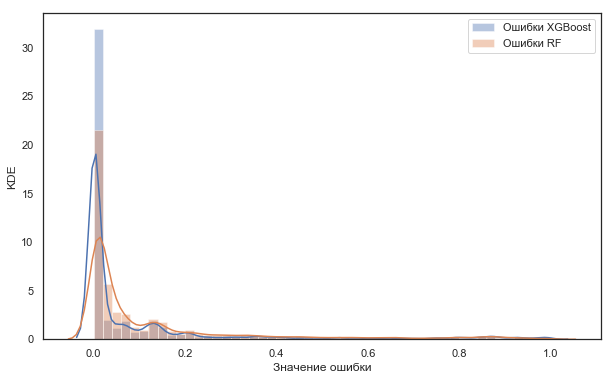

In [95]:
plt.figure(figsize=(10, 6))
sns.distplot(list(eps_xgb), label='Ошибки XGBoost')
sns.distplot(list(eps_rf), label='Ошибки RF')
plt.xlabel('Значение ошибки')
plt.ylabel('KDE')
plt.legend()
plt.show()

***Вывод:*** видим, что распределение ошибок XGBoost намного более плотное в районе нуля, чем распределение ошибок RandomForest, мы уже проверили, что данный результат является статистически значимым. 

In [107]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

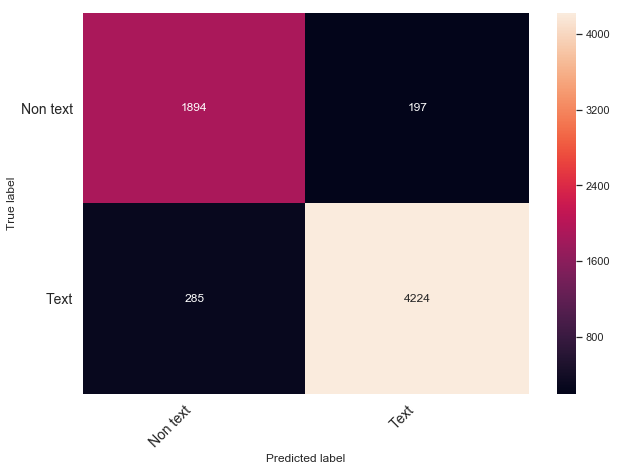

In [108]:
from sklearn.metrics import confusion_matrix
print_confusion_matrix(confusion_matrix(y_test, y_pred), class_names=['Non text', 'Text'])